![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

## Table of Contents

1. **[Part 1: Fine-Tuning BERT](#part1)**
   - 1.1. Loading and Exploring Data
   - 1.2. Loading a BERT from HF hub
   - 1.3. Training BERT
   - 1.4. Learning Curve - Model Evaluation

2. **[Part 2: Few Shot Learing](#part2)**
   - 2.1. Loading SetFit
   - 2.2. Training the SetFit with 32 examples
   - 2.3. Try to augment the data with prompt
   - 2.4. Model Evaluation

3. **[Part 3: Biases in BERT models - WinoGrad schemas](#part3)**
   - 3.1. Gender Biases
   - 3.2. Understanding of the agent



## Part 0: Load and Explore Data

Before diving into the model building and training, it's crucial to establish the metrics we'll use to evaluate our models. In this part, we will define and discuss the different metrics functions that are commonly used in NLP tasks, particularly for text classification:

1. **Accuracy**: Measures the proportion of correct predictions among the total number of cases examined. It's a straightforward metric but can be misleading if the classes are imbalanced.

2. **Precision and Recall**: Precision measures the proportion of positive identifications that were actually correct, while recall measures the proportion of actual positives that were identified correctly. These metrics are especially important when dealing with imbalanced datasets.

3. **F1 Score**: The harmonic mean of precision and recall. It's a good way to show that a classifer has a good balance between precision and recall.

4. **Confusion Matrix**: A table used to describe the performance of a classification model on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm.

5. **ROC and AUC**: The receiver operating characteristic curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system. The area under the curve (AUC) represents measure of separability.

We will implement these metrics functions using libraries such as scikit-learn, and they will be used to assess and compare the performance of our different models throughout this exercise.

In [1]:
!pip install datasets transformers==4.37.2

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.manifold import TSNE


from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
import pickle

import spacy
from spacy.matcher import Matcher

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt


import plotly.express as px

from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


/Users/andrewbennett/Documents/bse/term2/advanced_nlp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/andrewbennett/Documents/bse/term2/advanced_nlp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrewbennett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. **Metrics Functions**:

We will load the Rotten Tomatoes Movie Review corpus and perform necessary preprocessing steps like exploring the dataset.

In [3]:

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

### 2. **Loading and Exploring Data**:

We will load the Rotten Tomatoes Movie Review corpus and perform necessary preprocessing steps like exploring the dataset.

In [4]:

# Load the 'ag_news' dataset
dataset = load_dataset("rotten_tomatoes")

# Explore the structure of the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})


Let's create stratified samples for training and testation sets ensuring that each class is represented in proportion to its frequency. It will go faster with just a sample, and we will be able to make tests on validation test before trying to work on the testing set.

In [5]:
train_data = dataset['train']['text']
train_labels = dataset['train']['label']

valid_data = dataset['validation']['text']
valid_labels = dataset['validation']['label']

test_data = dataset['test']['text']
test_labels = dataset['test']['label']


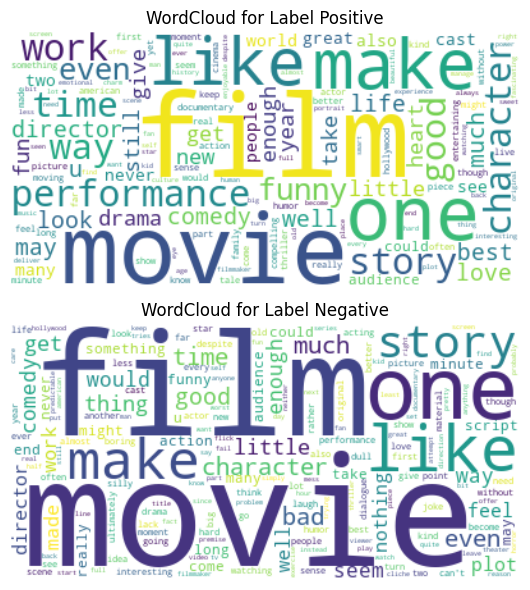

In [6]:

labels = {0: 'Negative', 1: 'Positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(train_data, train_labels):
    label_data[label] += text

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(2, 1, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()

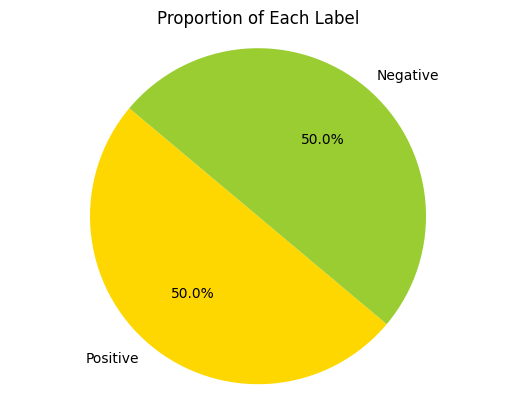

In [7]:

# Count the frequency of each label
label_counts = Counter(train_labels)

# Data to plot
_labels = [labels.get(lab) for lab in label_counts.keys()]
sizes = label_counts.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plotting the pie chart
plt.pie(sizes, labels=_labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Each Label')
plt.show()


### Baseline with TF-IDF + logistic regression

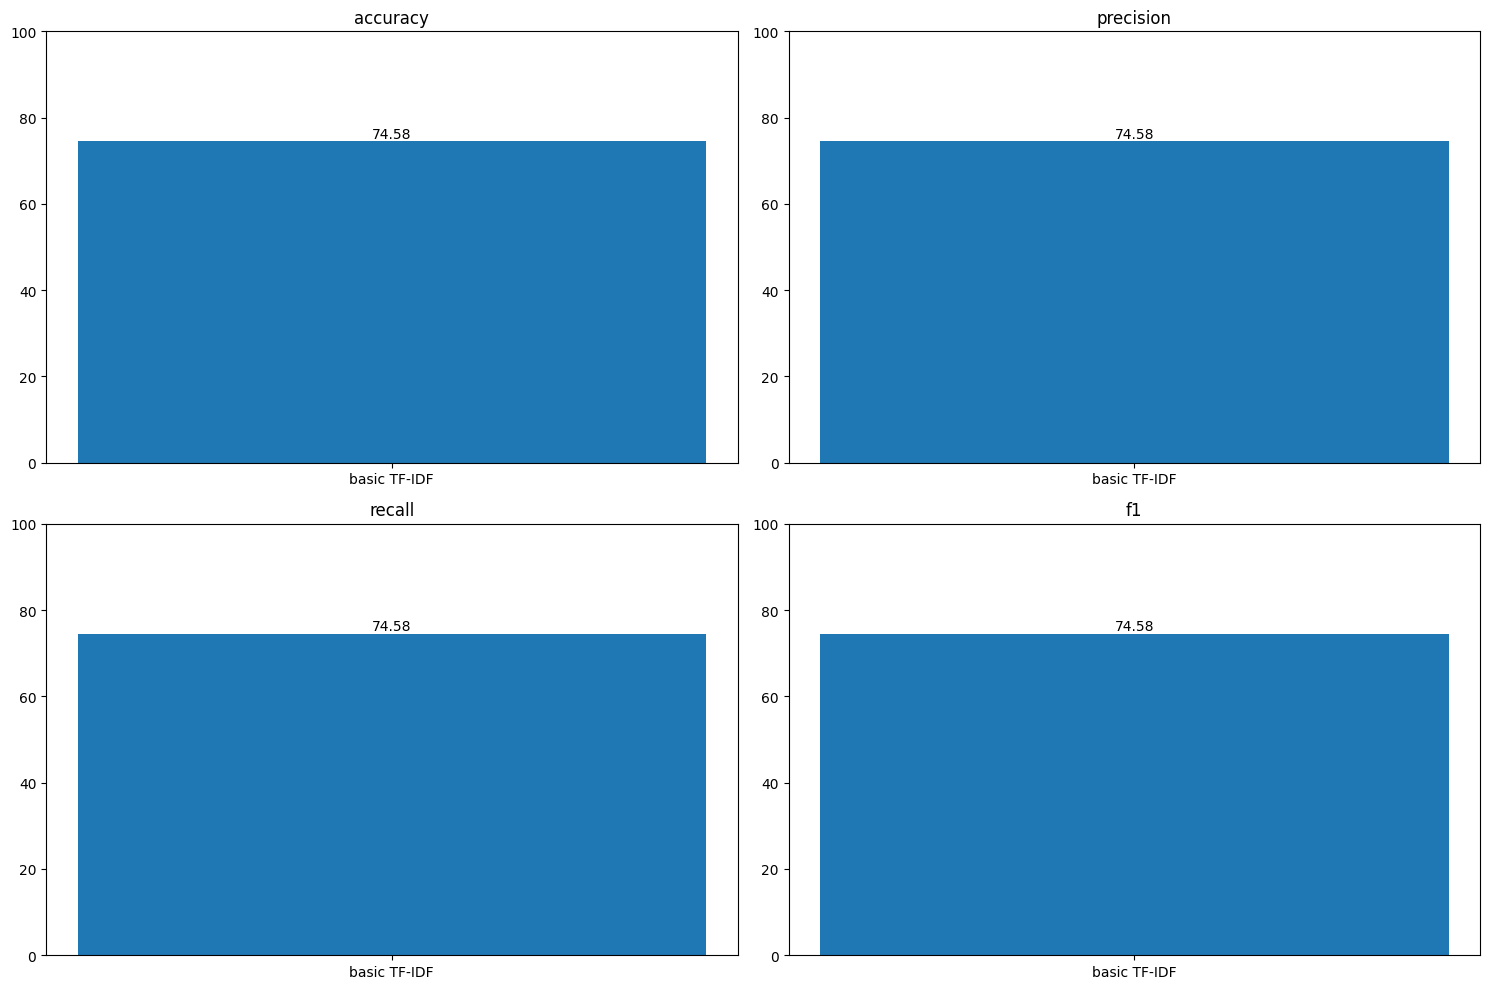

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline.fit(train_data, train_labels)

test_preds_tfidf = pipeline.predict(test_data)

metrics_val= Metrics()
metrics_val.run(test_labels, test_preds_tfidf, "basic TF-IDF")
metrics_val.plot()

# Part 1: BERT-like Model Training (3 points)

- Objective: Train a BERT-like model (BERT, DistilBERT, xtremedistill, etc.) on the Rotten Tomatoes dataset with a softmax layer on top of embeddings.

- Tasks:
1. Train the Model (1 point): Train your chosen model on the dataset and calculate accuracy, precision, recall, and F1-score.
2. Error Analysis (1 point): Analyze false positives and false negatives to identify potential improvements.
3. Feature Engineering (1 point): Implement your proposed improvements based on error analysis and show the impact on model performance.

### Train the Bert Model

In [9]:
from transformers import AutoTokenizer, TFAutoModel

checkpoint="distilbert-base-uncased"# let's go faster !
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=64
max=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(valid_labels))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Create Bert Model

In [10]:
import tensorflow as tf

## Input
input_ids_in = tf.keras.layers.Input(shape=(max,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# we need only the first token representation nothing else from the last layer!
final_embedding_layer = embedding_layer[0]#last layer of BERT
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 64, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                      

Let's generate some batches. Using the Bert batch encode plus to get encoded inputs and an attention mask.

In [11]:

def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

We now encode the `y_train` as a one hot encoder to have the four classes as in our architecture.

In [12]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

In [13]:
from tensorflow.keras.optimizers import Adam

X_train = np.array(train_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())


Depending on whether this is a local run, load the model from the saved weights, or fit the model.

In [14]:

#bert_model.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)
bert_model.load_weights("model_weights/bert_base_model_weights.h5")

In [15]:
# save weights
bert_model.save_weights("bert_base_model_weights.h5")

Create the test inputs and get some predictions.

34/34 [==============================] - 18s 517ms/step


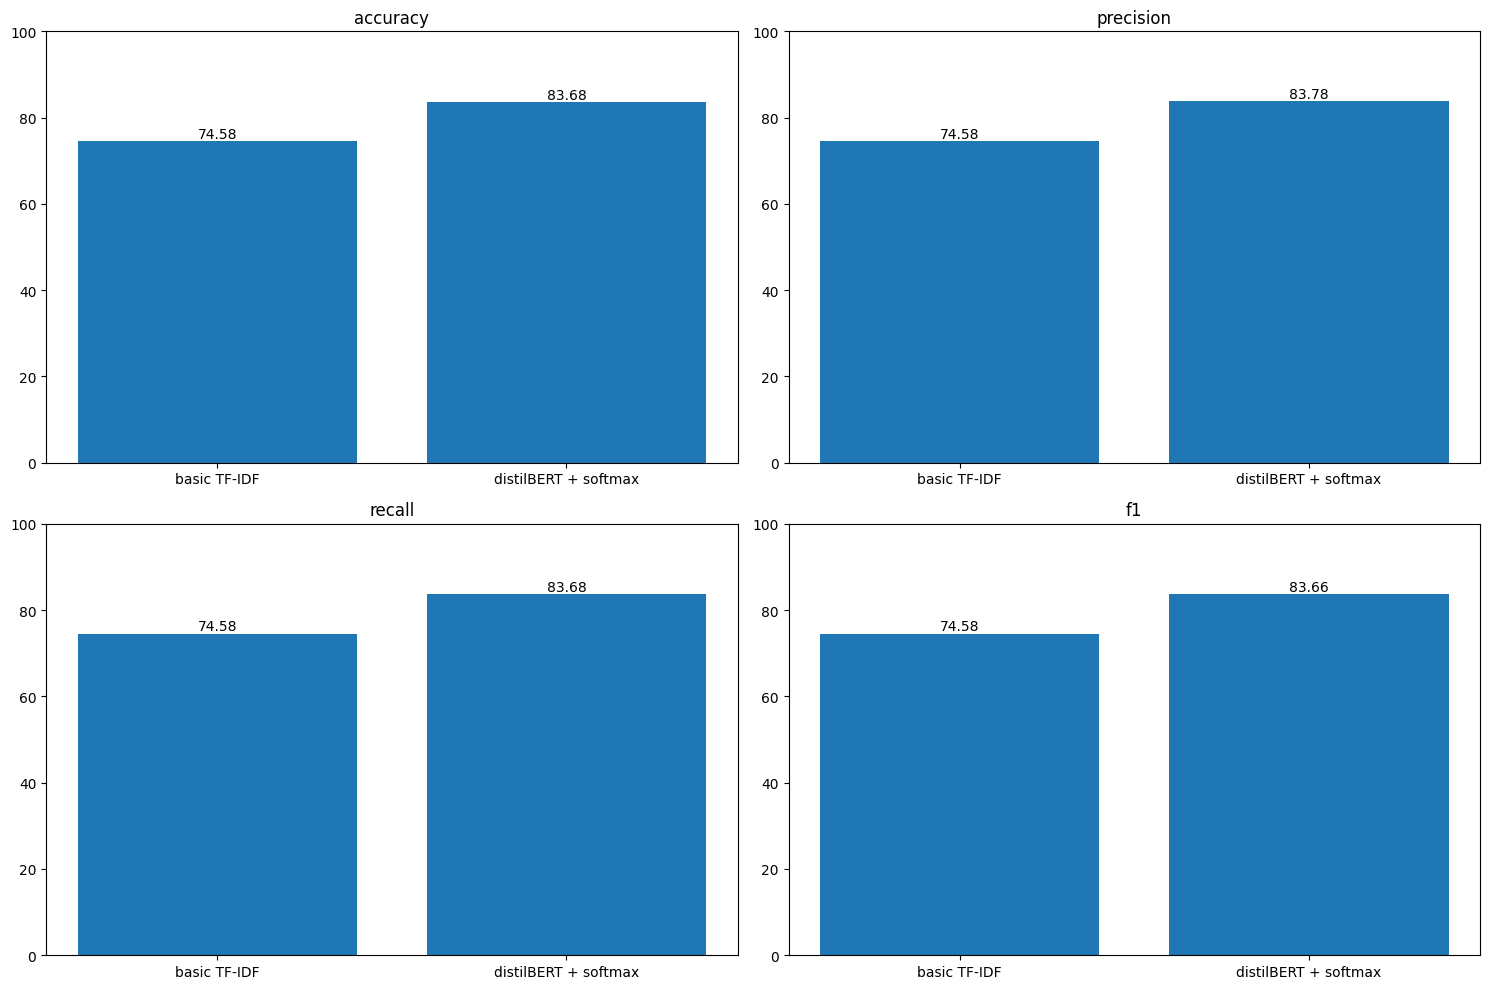

In [16]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds_baseline_bert = bert_model.predict(inputs_test)
test_preds_baseline_bert = np.argmax(test_preds_baseline_bert, axis=1)

# get the final metrics
metrics_val.run(test_labels, test_preds_baseline_bert, "distilBERT + softmax")
metrics_val.plot()

We can see across all fronts, we have increased in performance. The Precision + Recall increases tell us True Positives increased while False Negatives and False Positives have both decreased. The F1 Score is an indicator of the increase in both Precision and Recall.

### Error Analysis

#### Confusion Matrices

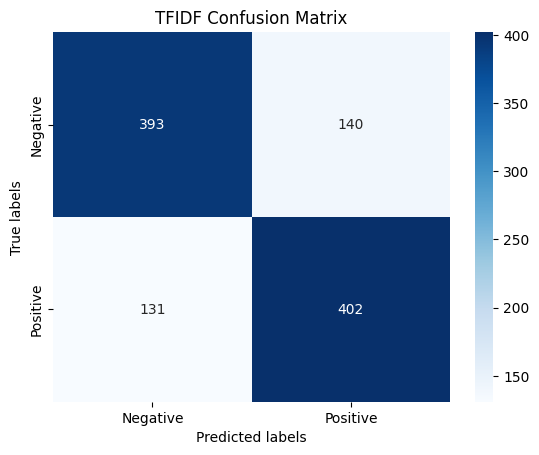

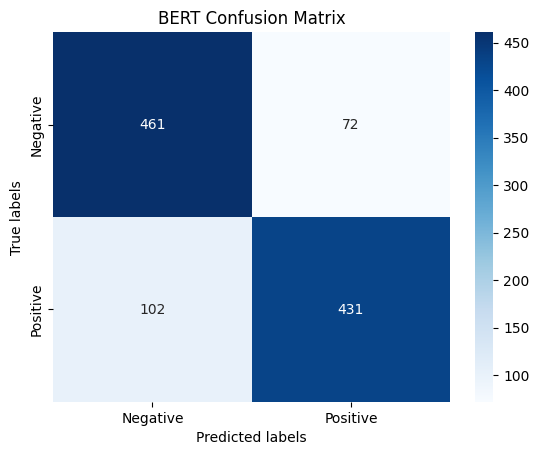

In [17]:


cm = confusion_matrix(test_labels, test_preds_tfidf)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('TFIDF Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()



cm = confusion_matrix(test_labels, test_preds_baseline_bert)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BERT Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

We can see above the outright value counts of False Negatives and False Positives decreased from the TFIDF model.

Now we will look into the bert model incorrect labels

In [18]:
investigation_data = pd.DataFrame(test_data)
investigation_data['bert_labels'] = test_preds_baseline_bert
investigation_data['test_labels'] = test_labels
investigation_data.columns = ['text', 'bert_labels', 'test_labels']

#### False Positives

First we look into False Positives

In [21]:
false_positives = list(investigation_data.loc[(investigation_data.bert_labels == 1) & (investigation_data.test_labels == 0), 'text'])
false_positives

['a film that will probably please people already fascinated by behan but leave everyone else yawning with admiration .',
 "the densest distillation of roberts' movies ever made .",
 "( it ) highlights not so much the crime lord's messianic bent , but spacey's .",
 'a film without surprise geared toward maximum comfort and familiarity .',
 "this is a children's film in the truest sense . it's packed with adventure and a worthwhile environmental message , so it's great for the kids . parents , on the other hand , will be ahead of the plot at all times , and there isn't enough clever innuendo to fil",
 'what ensues are much blood-splattering , mass drug-induced bowel evacuations , and none-too-funny commentary on the cultural distinctions between americans and brits .',
 'visually exciting sci-fi film which suffers from a lackluster screenplay .',
 'girlfriends are bad , wives are worse and babies are the kiss of death in this bitter italian comedy .',
 'ah , the travails of metropolitan

A lot of these incorrectly classified statements have one or two giveaway verbs, adjectives and adverbs that completely change the tone of the review. Specifically examples such as:

*   the movie is essentially a series of fleetingly interesting actors' moments
*   mildly entertaining

If there was a way to weight the adverb describing the adjective more that would likely increase result accuracy.

Additionally, many of these reviews start off with positive language then proceed to express a change of opinion. For example:

*   a sometimes incisive and sensitive portrait that is undercut by its awkward structure and a final veering toward melodrama
*   the movie does such an excellent job of critiquing itself at every faltering half-step of its development that criticizing feels more like commiserating
*   when 'science fiction' takes advantage of the fact that its intended audience hasn't yet had much science , it does a disservice to the audience and to the genre

By finding a sentence separator, or by subsequencing lengths of the text this may improve False Positive reduction.

__________________________________________________________________

#### False negatives

Now lets look at False Negatives

In [22]:
false_negatives = list(investigation_data.loc[(investigation_data.bert_labels == 0) & (investigation_data.test_labels == 1), 'text'])
false_negatives 


['it\'s like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .',
 'red dragon " never cuts corners .',
 'fresnadillo has something serious to say about the ways in which extravagant chance can distort our perspective and throw us off the path of good sense .',
 'mostly , [goldbacher] just lets her complicated characters be unruly , confusing and , through it all , human .',
 'at its worst , the movie is pretty diverting ; the pity is that it rarely achieves its best .',
 "the wonderfully lush morvern callar is pure punk existentialism , and ms . ramsay and her co-writer , liana dognini , have dramatized the alan warner novel , which itself felt like an answer to irvine welsh's book trainspotting .",
 "making such a tragedy the backdrop to a love story risks trivializing it , though chouraqui no doubt intended the film to affirm love's power to help people endure almost unimaginable horror .",
 "grown-up quibbles

One thing I notice from this output, is that most of these reviews have far more and longer length adjectives than the False Positive movie reviews. For example:

*   alternating between facetious comic parody and pulp melodrama , this smart-aleck movie . . . tosses around some intriguing questions about the difference between human and android life .
*   it arrives with an impeccable pedigree , mongrel pep , and almost indecipherable plot complications .
*   over the years , hollywood has crafted a solid formula for successful animated movies , and ice age only improves on it , with terrific computer graphics , inventive action sequences and a droll sense of humor .

#### Feature Engineering Analysis

Currently we can look into the adjective lengths and see if we can find a pattern to improve the model.

In [23]:
# create part of speech counts for each review
def get_pos_counts(df):
  pos_counts = {'noun':[],'adj':[],'adv':[],'verb':[], 'longest_noun':[], 'longest_verb':[], 'longest_adv':[], 'longest_adj':[]}

  for tokens in df:
    noun_count = 0
    verb_count = 0
    adj_count = 0
    adv_count = 0
    max_adj = 0
    max_adv = 0
    max_noun = 0
    max_verb = 0
    for token in tokens:
      token_len = len(str(token.text))
      if token.pos_ == 'ADJ':
        adj_count += 1
        if token_len > max_adj:
          max_adj = token_len
      elif token.pos_ == 'ADV':
        adv_count += 1
        if token_len > max_adv:
          max_adv = token_len
      elif token.pos_ == 'VERB':
        verb_count += 1
        if token_len > max_verb:
          max_verb = token_len
      elif token.pos_ == 'NOUN':
        noun_count += 1
        if token_len > max_noun:
          max_noun = token_len
    pos_counts['noun'].append(noun_count)
    pos_counts['adj'].append(adj_count)
    pos_counts['adv'].append(adv_count)
    pos_counts['verb'].append(verb_count)
    pos_counts['longest_noun'].append(max_noun)
    pos_counts['longest_adj'].append(max_adj)
    pos_counts['longest_adv'].append(max_adv)
    pos_counts['longest_verb'].append(max_verb)


  return pd.DataFrame(pos_counts)

In [24]:
test_tokenized_text = [nlp(x) for x in false_positives]
false_positives = get_pos_counts(test_tokenized_text)

test_tokenized_text = [nlp(x) for x in false_negatives]
false_negatives = get_pos_counts(test_tokenized_text)

In [34]:
# plot counts and lengths side by side in a bar graph in plotly express

mean_vals_FP = false_positives[['noun', 'adj', 'adv', 'verb']].mean()
mean_vals_FN = false_negatives[['noun', 'adj', 'adv', 'verb']].mean()

# Create a bar graph for the false positives and false negatives side by side in plotly express
x = ['Noun', 'Adj', 'Adv', 'Verb']
y_FP = [mean_vals_FP['noun'], mean_vals_FP['adj'], mean_vals_FP['adv'], mean_vals_FP['verb']]
y_FN = [mean_vals_FN['noun'], mean_vals_FN['adj'], mean_vals_FN['adv'], mean_vals_FN['verb']]

# Creating the figure
fig = px.bar(x=x, y=y_FP, labels={'x':'Part of Speech', 'y':'Mean Count'}, title='Mean POS Counts for False Positives')

# Adding bars for False Negatives
fig.add_bar(x=x, y=y_FN, name='False Negatives')

# Setting barmode to group
fig.update_layout(barmode='group')

# Showing the figure
fig.show()

In [36]:
# plot counts and lengths side by side in a bar graph in plotly express

mean_vals_FP = false_positives[['longest_noun', 'longest_adj', 'longest_adv', 'longest_verb']].mean()
mean_vals_FN = false_negatives[['longest_noun', 'longest_adj', 'longest_adv', 'longest_verb']].mean()

# Create a bar graph for the false positives and false negatives side by side in plotly express
x = ['Noun', 'Adj', 'Adv', 'Verb']
y_FP = [mean_vals_FP['longest_noun'], mean_vals_FP['longest_adj'], mean_vals_FP['longest_adv'], mean_vals_FP['longest_verb']]
y_FN = [mean_vals_FN['longest_noun'], mean_vals_FN['longest_adj'], mean_vals_FN['longest_adv'], mean_vals_FN['longest_verb']]

# Creating the figure
fig = px.bar(x=x, y=y_FP, labels={'x':'Part of Speech', 'y':'Mean Lengths'}, title='Mean POS Lengths for False Positives')

# Adding bars for False Negatives
fig.add_bar(x=x, y=y_FN, name='False Negatives')

# Setting barmode to group
fig.update_layout(barmode='group')

# Showing the figure
fig.show()

As per our hypothesis, we can see that the False Negatives have a higher average length of adjectives than the False Positives. This is a good indicator that we can use the part of speech lengths to improve the model. An interesting note is also the size and length of verbs in the FP and FN reviews. 

In summary, the observations have led to the following attempts for feature improvement:

*  creating a count of parts of speech and longest part of speech for each text segment
*   subset sentence length
*  putting emphasis / attention on the adverb of the adjective and verbs more



---



### Feature Engineering

#### Part of speech meta data input layer

Trying an approach to use part of speech data to enhance predictions. Specifically, adding a length of longest part of speech and count of part of speech to the nueral network.

##### Get metadata

In [37]:
train_tokenized_text = [nlp(x) for x in train_data]
valid_tokenized_text = [nlp(x) for x in valid_data]
test_tokenized_text = [nlp(x) for x in test_data]

train_metadata = get_pos_counts(train_tokenized_text)
test_metadata = get_pos_counts(test_tokenized_text)
valid_metadata = get_pos_counts(valid_tokenized_text)


In [38]:
train_metadata.describe()

,noun,adj,adv,verb,longest_noun,longest_verb,longest_adv,longest_adj
count,8530.000000,8530.000000,8530.000000,8530.000000,8530.000000,8530.000000,8530.000000,8530.000000
mean,4.518523,2.409965,1.246893,2.030012,8.435639,6.044431,4.666237,7.393787
std,2.579799,1.643562,1.243204,1.543154,2.843789,3.371064,4.112254,3.515109
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000,1.000000,7.000000,4.000000,0.000000,5.000000
50%,4.000000,2.000000,1.000000,2.000000,9.000000,7.000000,4.000000,8.000000
75%,6.000000,3.000000,2.000000,3.000000,10.000000,8.000000,8.000000,10.000000
max,16.000000,11.000000,8.000000,10.000000,18.000000,16.000000,18.000000,17.000000


##### Build Model

In [39]:
import tensorflow as tf

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')
metadata_input = tf.keras.Input(shape=(train_metadata.shape[1],), name='metadata_input')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)

# we need only the first token representation nothing else from the last layer!
final_embedding_layer = embedding_layer[0]#last layer of BERT

# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
bert_output = tf.keras.layers.Dense(64,
                               activation='relu')(output_layer)

# *** adding a input layer for the meta data

metadata_dense = tf.keras.layers.Dense(64, activation='relu')(metadata_input)

# *** combine metadata and other layer
combined = tf.keras.layers.concatenate([bert_output, metadata_dense])

combined_layer = tf.keras.layers.Dense(64, activation='relu')(combined)


output_layer = tf.keras.layers.Dense(num_labels, activation='softmax',
                                     kernel_initializer="glorot_uniform")(combined_layer)


bert_model_meta = tf.keras.Model(inputs=[input_ids_in, input_masks_in, metadata_input], outputs = output_layer)



bert_model_meta.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 64, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                    

##### Fit Model

Get batches and fit model

In [40]:
from sklearn.utils import shuffle

def get_batches_w_meta(X_train, X_meta, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max_length', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size], X_meta[i:i + batch_size]], y_train[i:i + batch_size]

In [41]:

batches = get_batches_w_meta(X_train, np.array(train_metadata), y_train, tokenizer, batch_size, max_length)


bert_model_meta.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())

In [43]:
#bert_model_meta.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)

bert_model_meta.load_weights("model_weights_bert_metadata.h5")

In [34]:
bert_model_meta.save_weights("model_weights_bert_metadata.h5")

#### Error Analysis

##### Metrics Plot

34/34 [==============================] - 18s 517ms/step


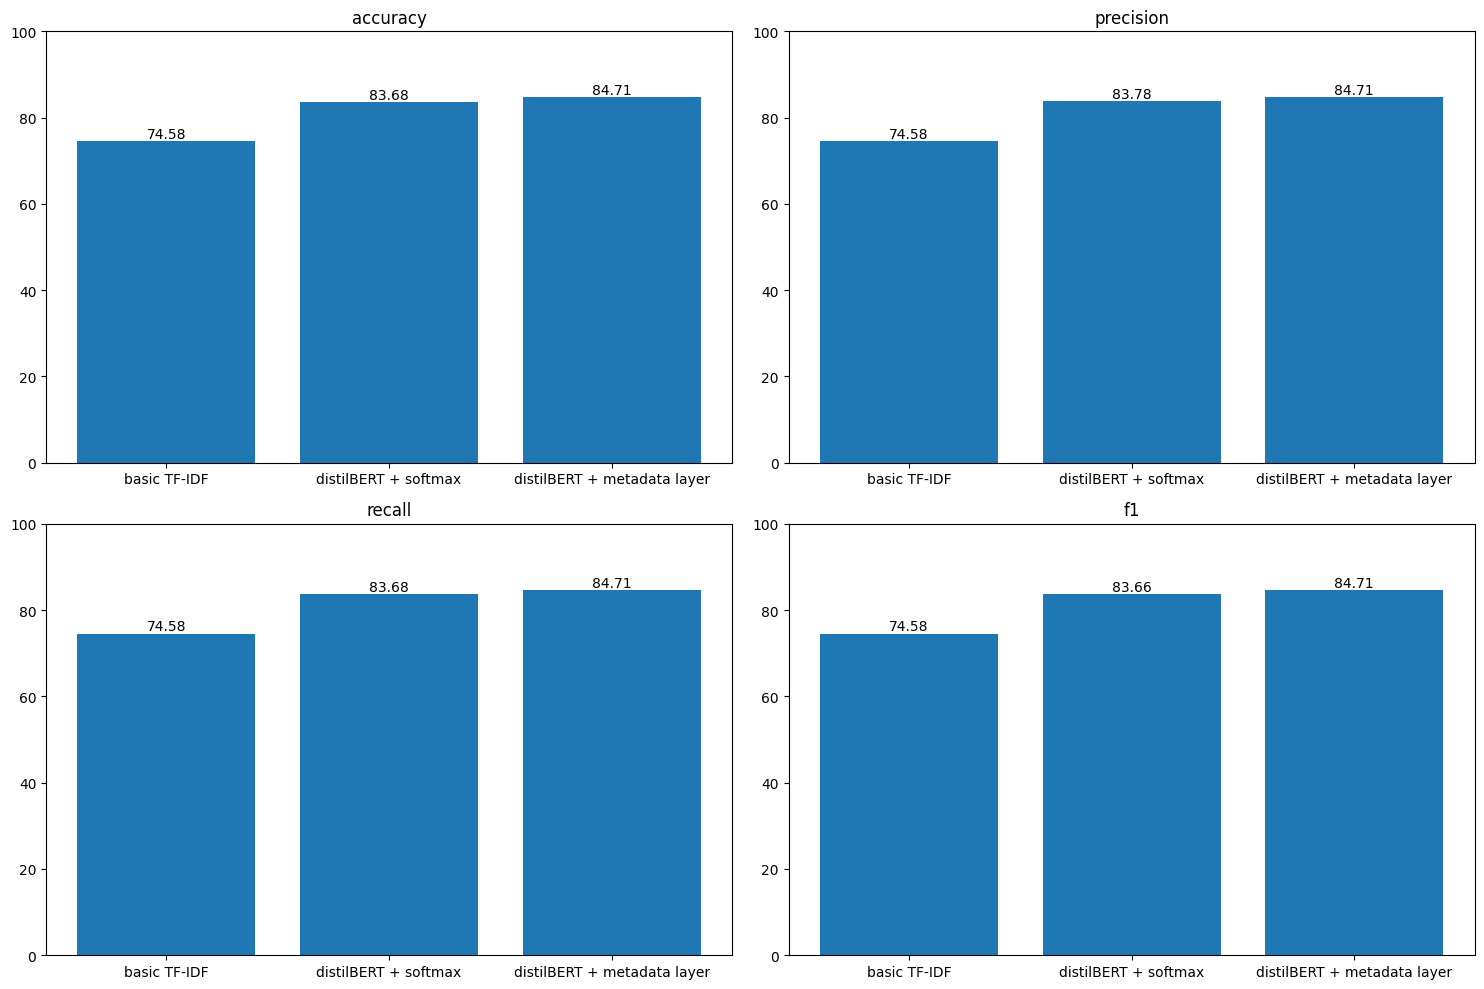

In [44]:

# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test_meta = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]

inputs_test_meta.append(np.array(test_metadata))

test_preds_bert_meta = bert_model_meta.predict(inputs_test_meta)
test_preds_bert_meta = np.argmax(test_preds_bert_meta, axis=1)

metrics_val.run(test_labels, test_preds_bert_meta, "distilBERT + metadata layer")
metrics_val.plot()

This approach looks to have worked, increasing the accuracy, precision and recall. F1 has increased which indicates an increase in True Positives and reduction in False Negatives and or False Positives.



---



##### Confusion matrices

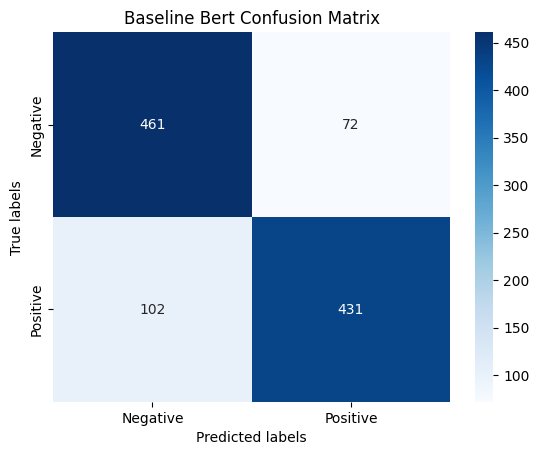

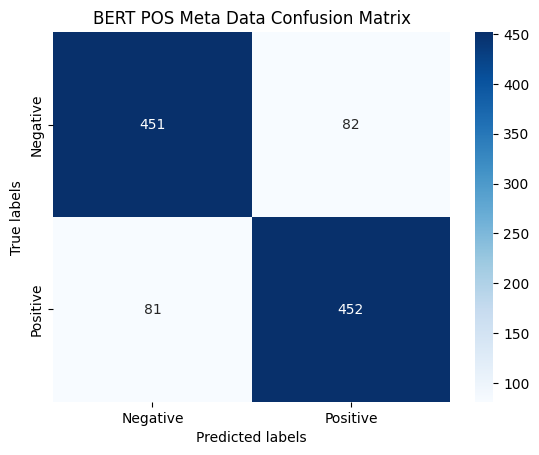

In [46]:


cm = confusion_matrix(test_labels, test_preds_baseline_bert)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Baseline Bert Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()



cm = confusion_matrix(test_labels, test_preds_bert_meta)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BERT POS Meta Data Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

Interestingly we see a more balanced classification of False Positives and False Negatives. This is a good sign that the model is learning more about the data. Additionally, as we expected adding the part of speech data has reduced false negatives. This may suggest that the hypothesis of longer adjectives in the False Negative results has been addressed.

##### False Positive and False Negative Analysis

In [68]:
# first create a dataframe with the valid labels and valid text data
test_df = pd.DataFrame(test_data)
test_df['test_labels'] = test_labels

# then add the predictions from the different models
test_df['test_preds_baseline_bert'] = test_preds_baseline_bert
test_df['test_preds_bert_meta'] = test_preds_bert_meta

test_df.columns = ['text', 'test_labels', 'test_preds_baseline_bert', 'test_preds_bert_meta']


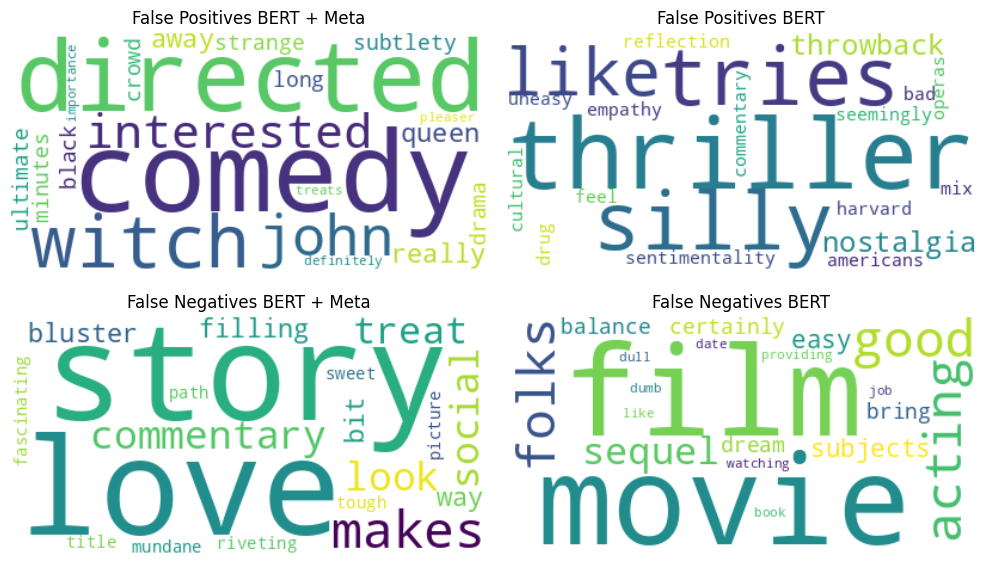

In [73]:
#
false_positives_bert_meta = list(test_df.loc[(test_df.test_preds_bert_meta == 1) & (test_df.test_labels == 0) & (test_df.test_preds_baseline_bert == 0), 'text'])
false_positives_bert = list(test_df.loc[(test_df.test_preds_bert_meta == 0) & (test_df.test_labels == 0) & (test_df.test_preds_baseline_bert == 1), 'text'])

false_negatives_bert_meta = list(test_df.loc[(test_df.test_preds_bert_meta == 0) & (test_df.test_labels == 1) & (test_df.test_preds_baseline_bert == 1), 'text'])
false_negatives_bert = list(test_df.loc[(test_df.test_preds_bert_meta == 1) & (test_df.test_labels == 1) & (test_df.test_preds_baseline_bert == 0), 'text'])

tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=2, stop_words='english')
tfidf.fit(test_data)

false_positives_bert_meta_tfidf = tfidf.transform(false_positives_bert_meta)
false_positives_bert_tfidf = tfidf.transform(false_positives_bert)

false_negatives_bert_meta_tfidf = tfidf.transform(false_negatives_bert_meta)
false_negatives_bert_tfidf = tfidf.transform(false_negatives_bert)


false_positives_bert_meta_df = pd.DataFrame(false_positives_bert_meta_tfidf.toarray(), columns=tfidf.get_feature_names_out())
false_positives_bert_df = pd.DataFrame(false_positives_bert_tfidf.toarray(), columns=tfidf.get_feature_names_out())

false_negatives_bert_meta_df = pd.DataFrame(false_negatives_bert_meta_tfidf.toarray(), columns=tfidf.get_feature_names_out())
false_negatives_bert_df = pd.DataFrame(false_negatives_bert_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# plot top 20 words for false positives and negatives
fig, axs = plt.subplots(2, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (df, title) in zip(axs, [(false_positives_bert_meta_df, 'False Positives BERT + Meta'), (false_positives_bert_df, 'False Positives BERT'),
                                    (false_negatives_bert_meta_df, 'False Negatives BERT + Meta'), (false_negatives_bert_df, 'False Negatives BERT')]):
        wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(df.sum().sort_values(ascending=False)[:20].to_string())
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(title)
        ax.axis('off')

plt.tight_layout()
plt.show()

False positives and False negatives for BERT + the meta data are interesting because they seem specific to certain genres of movies. 
    - comedy, queen, love

The baseline BERT model on the other hand, has a lot of generic words that are most important like
    - film, movie, good, silly, tries

This seems like a good sign that the model is now more balanced and has more specific words that are misclassified. This may indicate some type of bias in how the model is performing on different genres of movies. 

___

In future iterations I would ideally test  subsetting the data based on words like "but" and "though".  and to change the attention mask to just focus on adjectives, verbs and adverbs. I could also create a list of stop words from these most highly contributing words to the False Positives and False Negatives and remove them from the text.



---



## Part 2: Advanced Model Training with Embeddings (3 points)

- Objective: Enhance model understanding by considering all token embeddings and integrating an RNN.

- Tasks:
1. RNN Model Training (1 point): Train a RNN with a softmax layer on top of your BERT model using all token embeddings.
2. Model Comparison (1 point): Compare this model's performance with the one trained in Part 1. Highlight where the models perform different and propose some explanations based on your findings.
3. Token Importance (1 point): Identify which tokens contribute most to the decision-making process. For instance, look at the empiric probability of each token to be associated to the positive/negative class.



#### RNN Model Training

In [47]:
import tensorflow as tf

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
# we need only the first token representation nothing else !
embedding_layer = model(input_ids_in, attention_mask=input_masks_in)[0][:,0,:]
# Let's add some dropout to reduce overfitting
bert_output = tf.keras.layers.Dropout(rate, name='do_layer')(embedding_layer)

# Reshape the output to fit LSTM input shape
reshaped_output = tf.keras.layers.Reshape((-1, bert_output.shape[-1]))(bert_output)

# LSTM layer
lstm_output = tf.keras.layers.LSTM(units=64)(reshaped_output)

# Output layer
output = tf.keras.layers.Dense(2, activation='softmax')(lstm_output)

# Define the model
model_rnn = tf.keras.models.Model(inputs=[input_ids_in, input_masks_in], outputs=output)

# Compile the model
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# here we freeze the BERT layer so that we reduce overfitting, train time, and catastrophic forgetting (when it forgets pretrained tasks to learn new classification)
model_rnn.layers[2].trainable = False
model_rnn.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 64)]                 0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_token[0][0]',         
 stilBertModel)              den_state=(None, 64, 768),   0          'masked_token[0][0]']        
                              hidden_states=None, atten                                           
                             tions=None)                                                    

In [49]:
# import legacy adam optimizer
#from tensorflow.keras.optimizers import Adam


batches = get_batches(X_train,  y_train, tokenizer, batch_size, max_length)

model_rnn.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())



In [51]:
#model_rnn.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)
model_rnn.load_weights("model_weights_bert_rnn.h5")

In [40]:
# save model weights
model_rnn.save_weights("model_weights_bert_rnn.h5")

___

### Model Comparison

##### Metrics Plot

34/34 [==============================] - 19s 526ms/step


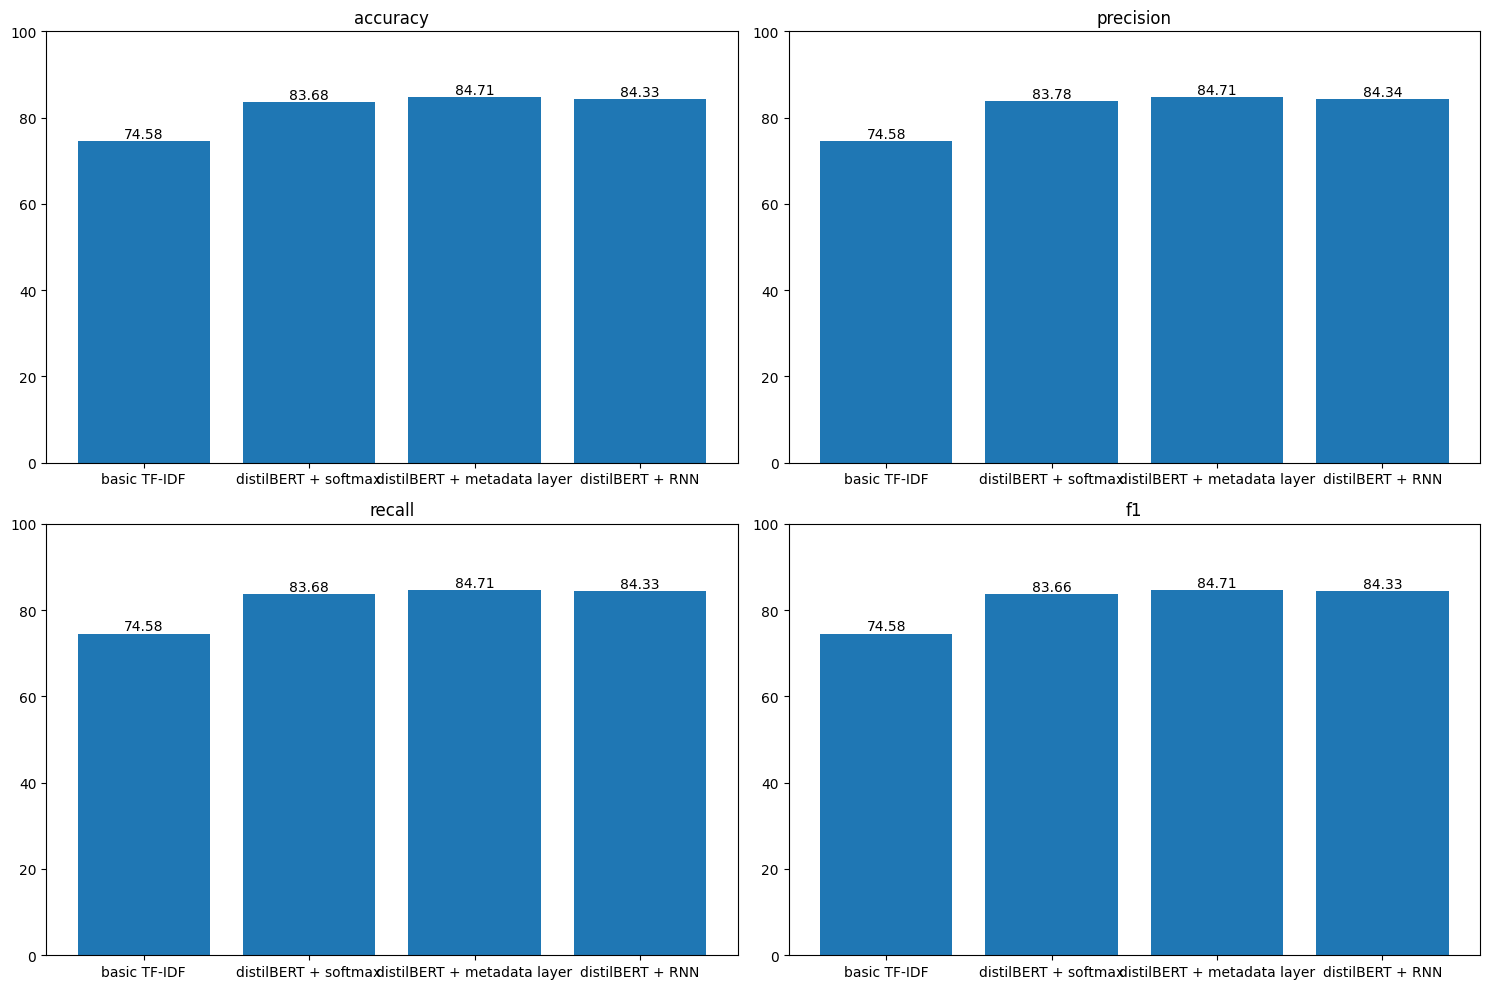

In [52]:
# Get the inputs tokenized from the validation set
inputs = tokenizer.batch_encode_plus(list(test_data),
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_test = [np.asarray(inputs['input_ids'], dtype='int32'),
               np.asarray(inputs['attention_mask'], dtype='int32')]
test_preds_rnn = model_rnn.predict(inputs_test)
test_preds_rnn = np.argmax(test_preds_rnn, axis=1)

# get the final metrics
metrics_val.run(test_labels, test_preds_rnn, "distilBERT + RNN")
metrics_val.plot()

This model performs about the same as the previous models. There has been no significant improvements with the RNN given the results of the Precision and Recall. The F1 score is also about the same. The accuracy is also about the same. We will have to look at how the model is finding False Positives and False Negatives

##### TSNE Plot
Creating a TSNE plot to see the distribution of the RNN model.

34/34 [==============================] - 18s 498ms/step


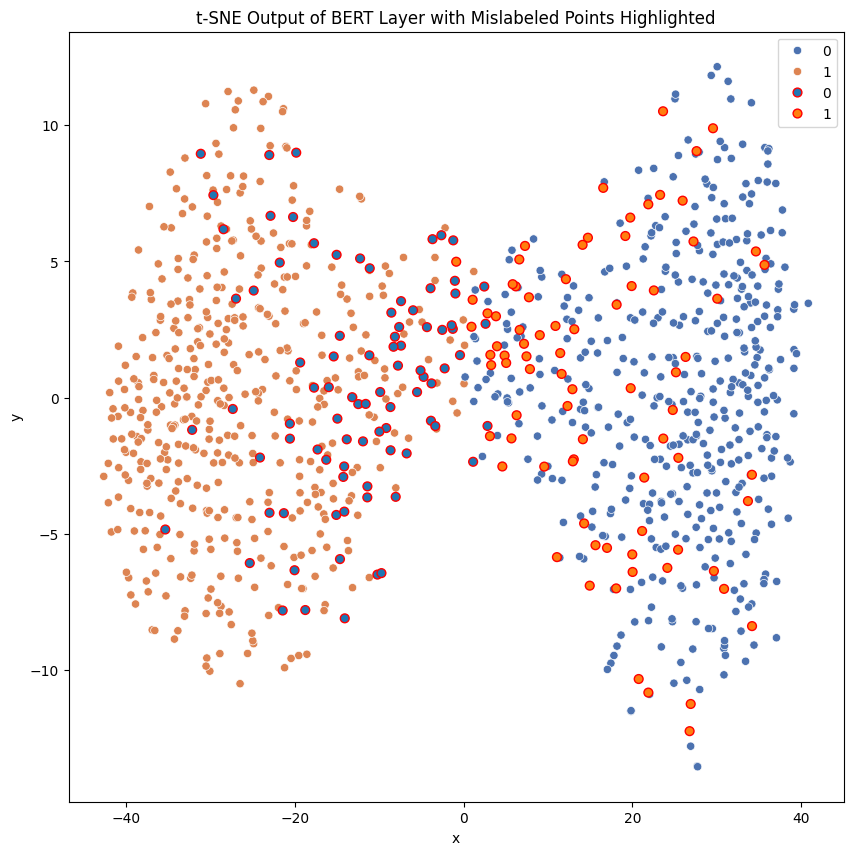

In [53]:

# Create a model to get the outputs of BERT layer from rnn model
model_with_layer_output = tf.keras.Model(inputs=model_rnn.input, outputs=model_rnn.get_layer('do_layer').output)

outputs = model_with_layer_output.predict(inputs_test)

# based on the outputs of the BERT layer, we can use t-SNE to visualize the data

tsne = TSNE(n_components=2, random_state=0)
tsne_output = tsne.fit_transform(outputs)

# Create a dataframe with the t-SNE output
tsne_df = pd.DataFrame(tsne_output, columns=['x', 'y'])
tsne_df['label'] = test_labels
tsne_df['pred_rnn'] = test_preds_rnn
tsne_df['mislabeled'] = tsne_df['label'] != tsne_df['pred_rnn']
tsne_df['mislabeled'] = tsne_df['mislabeled'].astype(int)
# the x and y values represent the similarity of the data points in a 2D space

plt.figure(figsize=(10, 10))
# Plot correctly labeled points
sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, palette='deep')
# Plot mislabeled points with circles around them
sns.scatterplot(x='x', y='y', data=tsne_df[tsne_df.mislabeled == 1], hue='label', edgecolor='red', linewidth=1, s=40)
plt.title('t-SNE Output of BERT Layer with Mislabeled Points Highlighted')
plt.legend()
plt.show()

##### Confusion Matrices

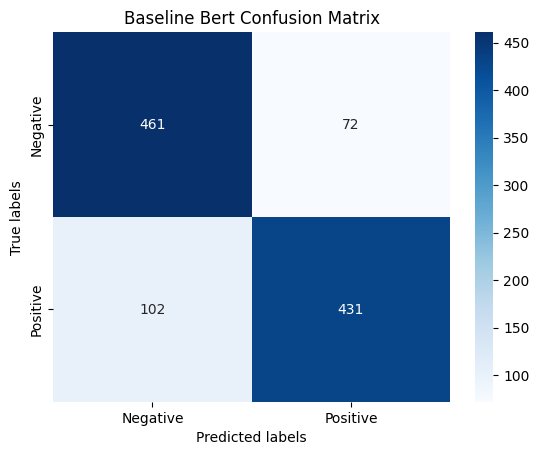

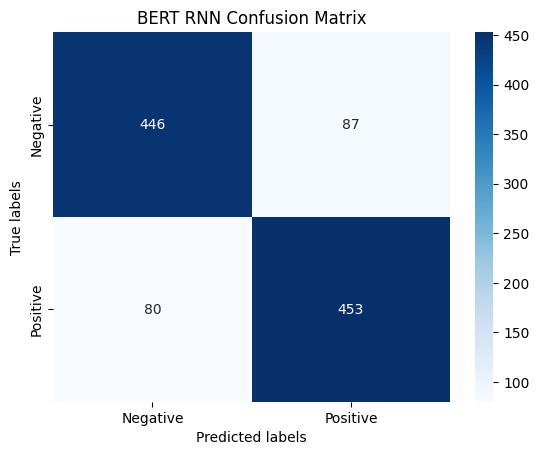

In [57]:


cm = confusion_matrix(test_labels, test_preds_baseline_bert)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Baseline Bert Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()



cm = confusion_matrix(test_labels, test_preds_rnn)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BERT RNN Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

Similar to the Meta Data model, the RNN is also more balanced in the False Positives and False Negatives, but has increased the number of False Positives more than the False Negatives.

In [58]:
# first create a dataframe with the valid labels and valid text data
test_df = pd.DataFrame(test_data)
test_df['test_labels'] = test_labels

# then add the predictions from the different models
test_df['test_preds_baseline_bert'] = test_preds_baseline_bert
test_df['test_preds_rnn'] = test_preds_rnn

test_df.columns = ['text', 'test_labels', 'test_preds_baseline_bert', 'test_preds_rnn']

##### False Positives comparison

In [59]:

false_positives_rnn = list(test_df.loc[(test_df.test_preds_rnn == 1) & (test_df.test_labels == 0) & (test_df.test_preds_baseline_bert == 0), 'text'])
false_positives_rnn

['the niftiest trick perpetrated by the importance of being earnest is the alchemical transmogrification of wilde into austen--and a hollywood-ized austen at that .',
 'if anything , see it for karen black , who camps up a storm as a fringe feminist conspiracy theorist named dirty dick .',
 'in a 102-minute film , aaliyah gets at most 20 minutes of screen time . . . . most viewers will wish there had been more of the " queen " and less of the " damned . "',
 'in gleefully , thumpingly hyperbolic terms , it covers just about every cliche in the compendium about crass , jaded movie types and the phony baloney movie biz .',
 'disappointing in comparison to other recent war movies\x85or any other john woo flick for that matter .',
 'if it were any more of a turkey , it would gobble in dolby digital stereo . if nothing else , " rollerball " 2002 may go down in cinema history as the only movie ever in which the rest of the cast was outshined by ll cool j .',
 "as his circle of friends keeps 

In [56]:
false_positives_bert = list(test_df.loc[(test_df.test_preds_rnn == 0) & (test_df.test_labels == 0) & (test_df.test_preds_baseline_bert == 1), 'text'])
false_positives_bert

['what ensues are much blood-splattering , mass drug-induced bowel evacuations , and none-too-funny commentary on the cultural distinctions between americans and brits .',
 "the ethos of the chelsea hotel may shape hawke's artistic aspirations , but he hasn't yet coordinated his own dv poetry with the beat he hears in his soul .",
 'the punch lines that miss , unfortunately , outnumber the hits by three-to-one . but death to smoochy keeps firing until the bitter end .',
 "lyne's latest , the erotic thriller unfaithful , further demonstrates just how far his storytelling skills have eroded .",
 'although it starts off so bad that you feel like running out screaming , it eventually works its way up to merely bad rather than painfully awful .',
 'an uneasy mix of run-of-the-mill raunchy humor and seemingly sincere personal reflection .',
 'time literally stops on a dime in the tries-so-hard-to-be-cool " clockstoppers , " but that doesn\'t mean it still won\'t feel like the longest 90 minu

In [61]:
print('number of UNIQUE baseline BERT false positives: ' + str(len(false_positives_bert)))
print('number of UNIQUE RNN BERT false positives: ' + str(len(false_positives_rnn)))

number of UNIQUE baseline BERT false positives: 9
number of UNIQUE RNN BERT false positives: 24


The unique FP difference between the two models suggest that learning tasks have definitely diverged (more so for the RNN model). 

A lot of the RNN  statements have sarcasm built in, where they start positive and end negative. Usually using a word like 'but' or 'though' to change the tone. For example:

 *   'little more than a stylish exercise in revisionism whose point . . . is no doubt true , but serves as a rather thin moral to such a knowing fable .',
 *   'definitely a crowd-pleaser , but then , so was the roman colosseum .',
 *   "certainly not a good movie , but it wasn't horrible either ."

The unique False Positives from the baseline BERT model are more generic and less sarcastic. However, they have more dual meaning words like 'silly' and 'humor' which can be interpreted either way. 



___

##### False Negatives Comparison

Now we can look into the false negatives unique to the RNN model

In [64]:
false_negatives_rnn = list(test_df.loc[(test_df.test_preds_rnn == 0) & (test_df.test_labels == 1) & (test_df.test_preds_baseline_bert == 1), 'text'])
false_negatives_rnn

['weighty and ponderous but every bit as filling as the treat of the title .',
 'the comedy makes social commentary more palatable .',
 "this amiable picture talks tough , but it's all bluster -- in the end it's as sweet as greenfingers . . .",
 "gambling and throwing a basketball game for money isn't a new plot -- in fact toback himself used it in black and white . but toback's deranged immediacy makes it seem fresh again .",
 'missteps take what was otherwise a fascinating , riveting story and send it down the path of the mundane .',
 'an almost unbearably morbid love story .']

Interestingly the RNN bert fewer unique false negatives.

In [62]:
false_negatives_bert = list(test_df.loc[(test_df.test_preds_rnn == 1) & (test_df.test_labels == 1) & (test_df.test_preds_baseline_bert == 0), 'text'])
false_negatives_bert

['mostly , [goldbacher] just lets her complicated characters be unruly , confusing and , through it all , human .',
 "the wonderfully lush morvern callar is pure punk existentialism , and ms . ramsay and her co-writer , liana dognini , have dramatized the alan warner novel , which itself felt like an answer to irvine welsh's book trainspotting .",
 "grown-up quibbles are beside the point here . the little girls understand , and mccracken knows that's all that matters .",
 '. . . a good film that must have baffled the folks in the marketing department .',
 'the performances are immaculate , with roussillon providing comic relief .',
 'hugh grant , who has a good line in charm , has never been more charming than in about a boy .',
 "[scherfig] has made a movie that will leave you wondering about the characters' lives after the clever credits roll .",
 "williams absolutely nails sy's queasy infatuation and overall strangeness .",
 'can i admit xxx is as deep as a petri dish and as well-ch

In [65]:
print('number of baseline bert false negatives: ' + str(len(false_negatives_bert)))
print('number of RNN bert false negatives: ' + str(len(false_negatives_rnn)))

number of baseline bert false negatives: 28
number of RNN bert false negatives: 6


The unique FN difference between the two models suggest that learning tasks have definitely diverged and the unique count reflects the differences seen in the confusion matrices. 

The False Negatives from the RNN model are difficult to interpret even reading as a human

Again there is one or two words that act as a giveaway, where the reviewer starts off negative and ends positive or vice versa. 

Again, there is a recurring theme of generic words like 'thriller' or 'love' that are used in the False Negatives, which may be a sign that there is a genre bias. 

There is also more generic recurring words in these FP and FN groups that may indicate a group of stop words that can be identified.

##### Full Comparative analysis

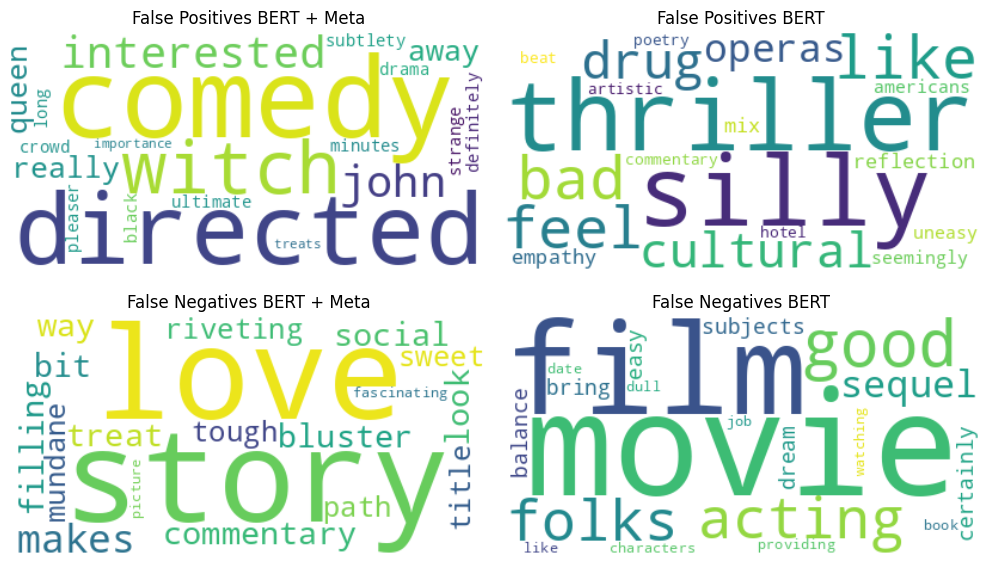

In [82]:

tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=2, stop_words='english')
tfidf.fit(test_data)

false_positives_rnn_tfidf = tfidf.transform(false_positives_rnn)
false_positives_bert_tfidf = tfidf.transform(false_positives_bert)

false_negatives_rnn_tfidf = tfidf.transform(false_negatives_rnn)
false_negatives_bert_tfidf = tfidf.transform(false_negatives_bert)


false_positives_rnn_df = pd.DataFrame(false_positives_rnn_tfidf.toarray(), columns=tfidf.get_feature_names_out())
false_positives_bert_df = pd.DataFrame(false_positives_bert_tfidf.toarray(), columns=tfidf.get_feature_names_out())

false_negatives_rnn_df = pd.DataFrame(false_negatives_rnn_tfidf.toarray(), columns=tfidf.get_feature_names_out())
false_negatives_bert_df = pd.DataFrame(false_negatives_bert_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# plot top 20 words for false positives and negatives
fig, axs = plt.subplots(2, 2, figsize=(10, 6))  # Create 2x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (df, title) in zip(axs, [(false_positives_bert_meta_df, 'False Positives BERT + Meta'), (false_positives_bert_df, 'False Positives BERT'),
                                    (false_negatives_bert_meta_df, 'False Negatives BERT + Meta'), (false_negatives_bert_df, 'False Negatives BERT')]):
        wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(df.sum().sort_values(ascending=False)[:20].to_string())
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(title)
        ax.axis('off')

plt.tight_layout()
plt.show()


After reviewing the wordclouds, the most prominent two avenues for expansion are

* creating a generic stopwords removal function with words such as: film, movie, silly
* addressing the genre bias of words like: love, thriller, comedy, witch, queen

### Token Importance



#### RF Feature importance

In [69]:


pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=11))
])

# create a grid parameter for the count vectorizer
grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__min_df': [.01, .1],
    'vectorizer__max_df': [0.4, 0.5],
    'vectorizer__max_features': [1000, 2000, 3000, 4000, 5000]
}

grid_search = GridSearchCV(pipeline, grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(train_data, train_labels)

# visualize most feature importance for each class

vectorizer = grid_search.best_estimator_.named_steps['vectorizer']
clf = grid_search.best_estimator_.named_steps['clf']

# get the feature importance of the random forest classifier
importances = clf.feature_importances_

# get the feature names from the count vectorizer
feature_names = vectorizer.get_feature_names_out()

# create a dataframe with the feature names and their importance
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# get the top 20 most important features for each class
top20_features = feature_importance_df.sort_values(by='importance', ascending=False).head(20)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [70]:
# plot the top 20 most important features for each class
fig = px.bar(top20_features, x='feature', y='importance', title='Top 20 Most Important Features for Classification')
fig.show()

The previous hypothesis of generic words being important in the BERT model is confirmed by the feature importance of the Random Forest model. The thought here is that because these words have no positive or negative sentiment associated with them they should not be top features for classification. 

An ideal next step would be to remove these words and other non biased words from the text and see if the model improves. 

We could potentially create a sentiment score of each word and only use words that have some positive or negative sentiment over a certain threshold. 

#### RF False Positive Words

In [73]:
# for each word in the false positives and false negatives, get probability of class
# create a list of all words
all_false_positive_words = nlp(' '.join(test_df.loc[(test_df.test_preds_rnn == 1) & (test_df.test_labels == 0), 'text']))

class_probs_0 = []
class_probs_1 = []

for word in all_false_positive_words:
    preds = grid_search.predict_proba([word.text])
    class_probs_0.append(preds[0][0])
    class_probs_1.append(preds[0][1])

# create a dataframe with the words and their probabilities
false_positive_probs = pd.DataFrame({'word': all_false_positive_words, 'class_0_prob': class_probs_0, 'class_1_prob': class_probs_1})
false_positive_probs['word'] = false_positive_probs['word'].astype(str)

false_positive_probs = false_positive_probs.groupby('word')['class_1_prob'].mean()

false_positive_probs = pd.DataFrame(false_positive_probs)
top_20 = false_positive_probs.sort_values(by='class_1_prob', ascending=False).head(20)


# plot top 20 words with highest probability of being class 1
fig = px.bar(top_20, x=top_20.index, y='class_1_prob', title='Top 20 False Positive Words with Highest Probability of Being Class 1')
fig.show()


The False Positive words here indicate a strong genre bias. Family, documentary, romantic, drama, american, all seem to be words that are contributing to the incorrect classification. This may be a sign that the model is classifying all drama movies as positive.

#### RF False Negative Words

In [74]:
# for each word in the false positives and false negatives, get probability of class
# create a list of all words
all_false_negative_words = nlp(nlp(' '.join(test_df.loc[(test_df.test_preds_rnn == 0) & (test_df.test_labels == 1), 'text'])))

class_probs_0 = []
class_probs_1 = []

for word in all_false_negative_words:
    preds = grid_search.predict_proba([word.text])
    class_probs_0.append(preds[0][0])
    class_probs_1.append(preds[0][1])

# create a dataframe with the words and their probabilities
false_negative_probs = pd.DataFrame({'word': all_false_negative_words, 'class_0_prob': class_probs_0, 'class_1_prob': class_probs_1})
false_negative_probs.word = false_negative_probs.word.astype(str)
false_negative_probs = false_negative_probs.groupby('word')['class_0_prob'].mean()

false_negative_probs = pd.DataFrame(false_negative_probs)
top_20 = false_negative_probs.sort_values(by='class_0_prob', ascending=False).head(20)


# plot top 20 words with highest probability of being class 1
fig = px.bar(top_20, x=top_20.index, y='class_0_prob', title='Top 20 False Negative Words with Highest Probability of Being Class 0')
fig.show()

In the False Negative words, we see a lot of generic words that are not necessarily positive or negative. This indicates that the model would benefit from more stopwords. 

Additionally, there is interesting correlation between the generic words in the False Negatives, and the generic words as overall contributors to the model. This may mean that the model is better at classifying negatives than it is at classifying positives.

## Part 3: Bias Analysis (3 points)

- Objective: Identify and mitigate potential biases in your sentiment analysis model.

- Tasks:
1. Bias Identification (1.5 points): Identify a potential bias in your model's predictions. Explicit what bias you're trying to identify, your investigation hypothesis and your method. Propose an explanation of why this bias exist.
2. Mitigation Technique (1.5 points): Propose and describe a technique to mitigate the identified bias, ensuring the solution is specific to your case by looking at examples.

### Bias identification

As seen from the incorrect classification analysis. Words like "comedy" and "drama" are some of the highest indicators for false positives and false negatives. That indicates that there may be bias in the model based on the genre of the movie.

#### Bias with Data

Here is a graph of the share of movies by box office grossing. This indicates a large difference in the quantity of movies. Also if we were to use $ value as an indicator of quality, there is also a large difference in quality. We will use the top 4 categories for our Bias analysis.

In [75]:
import re
movie_data = pd.read_csv('movie_data.csv')
# remove all non-alphabetic characters from Gross
movie_data['Gross'] = movie_data['Gross'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
movie_data['Gross'] = movie_data['Gross'].astype(int)


#plot movie data in a bar graph plotly express
fig = px.bar(movie_data, x='Genre', y='Gross', title='Movies by $')
fig.show()

#### Word Replacement Bias Identification
Here we look at a standard set of reviews, and replace only a single word in the sentences. Then test the bias.

In [76]:
# give an example of gender biased statements
generic_reviews = ["{genre} movie was a wild ride! Spectacular visuals and gripping plot made it a must-watch.",
                    "The movie was a thrilling {genre}. The plot was engaging and the visuals were stunning.",
                    "{genre} film lacked depth. Weak characters and predictable storyline left me underwhelmed.",
                    "{genre} flick was an adrenaline rush! Non-stop {genre} and stunning visuals kept me hooked.",
                     "{genre} movie exceeded expectations! Riveting plot, captivating characters, and breathtaking scenery made it an unforgettable journey.",
                     "{genre} film fell flat. Shallow characters, lackluster plot, and uninspired {genre} left me unengaged and disappointed."
]

labels = []
all_reviews = []

for genre in ['action', 'comedy', 'drama', 'adventure']:
    for review in generic_reviews:

        labels.append(genre)
        all_reviews.append(review.format(genre=genre))

inputs_2 = tokenizer.batch_encode_plus(all_reviews,
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid_2 = [np.asarray(inputs_2['input_ids'], dtype='int32'),
               np.asarray(inputs_2['attention_mask'], dtype='int32')]
preds = model_rnn.predict(inputs_valid_2)

1/1 [==============================] - 1s 536ms/step


In [57]:
results_df = pd.DataFrame(all_reviews)
results_df['preds'] = preds[:,-1]
results_df['movie_type_bias'] = labels
prompt_types = [1,2,3,4,5,6] * 4
results_df['prompt_types'] = prompt_types

results_df = results_df.sort_values(by='preds', ascending=False)
results_df = results_df.sort_values(by='prompt_types', ascending=True)

# plot the results in a grouped bar chart
fig = px.bar(results_df, x='prompt_types', y='preds', color='movie_type_bias', title='Model Predictions for Movie Types', barmode='group')
fig.show()


Changing the genre title alone, indicates there is larger levels of positive classification for Adventure and Drama movie types.

#### LLM Generated Bias Identification
Here we confirm bias by using LLM generated movie reviews, which use more language and have more variation between the genres, whereas the previous constant statements had static language across the reviews.

In [77]:
adventure_reviews = [
    "An epic adventure that takes you on a journey of discovery and wonder! From breathtaking landscapes to thrilling escapades, this movie is a masterpiece of storytelling. A must-watch for adventurers of all ages!",
"Embark on a cinematic adventure like no other! With daring heroes, treacherous villains, and ancient mysteries waiting to be uncovered, this film will ignite your imagination and leave you craving for more.",
"Prepare to be swept away on an exhilarating adventure across uncharted territories! With heart-pounding action and breathtaking visuals, this movie delivers excitement at every turn. Don't miss it!",
"A swashbuckling adventure that will leave you breathless! From daring escapes to pulse-pounding showdowns, this film has it all. Strap in for a wild ride you won't soon forget!",
"Get ready for the adventure of a lifetime! Join our intrepid heroes as they journey into the unknown, facing danger and discovery at every turn. An action-packed thrill ride from start to finish!",
"An unforgettable adventure that will capture your imagination and steal your heart! With stunning visuals and a gripping storyline, this movie transports you to a world of excitement and wonder."
]

action_reviews = [
    "An adrenaline-fueled thrill ride from start to finish! Jaw-dropping stunts and intense action sequences make this a must-watch for any action fan. 5 stars!",
"Action-packed with a capital A! Explosions, car chases, and epic fight scenes deliver non-stop excitement. It's like a roller coaster for your adrenaline. Highly recommended!",
"A popcorn-munching, edge-of-your-seat extravaganza! This movie delivers the goods with heart-pounding action and a hero you can root for. Strap in and enjoy the ride!",
"The perfect blend of heart-stopping action and gripping storytelling. You'll be on the edge of your seat from the opening scene to the epic finale. Don't miss it!",
"An action movie that packs a punch! From the breathtaking visuals to the adrenaline-pumping soundtrack, this film delivers thrills in spades. A true cinematic experience!",
"Buckle up for a wild ride! This action-packed movie delivers everything you could want and more. Explosive set pieces, high-octane chases, and a hero who doesn't quit. 10/10!"
]

drama_reviews = [
"A gripping drama that tugs at the heartstrings and leaves a lasting impact. With powerful performances and a thought-provoking storyline, this film is a testament to the human spirit.",
"An emotional rollercoaster that takes you on a journey of love, loss, and redemption. With stunning cinematography and raw, authentic performances, this movie is a true masterpiece.",
"Prepare to be moved to tears by this poignant drama. With its compelling narrative and deeply relatable characters, this film resonates long after the credits roll.",
"A captivating drama that explores the complexities of the human experience. With its richly drawn characters and evocative storytelling, this movie is a must-see for fans of the genre.",
"A thought-provoking drama that challenges the audience to confront difficult truths about life and love. With its powerful message and stellar performances, this film is sure to leave a lasting impression.",
"An intimate drama that delves into the intricacies of relationships and the search for meaning. With its raw emotion and nuanced performances, this movie is a masterclass in storytelling."

]
comedy_reviews = [
    "A laugh-out-loud comedy that delivers non-stop hilarity from start to finish. With its witty dialogue and hilarious antics, this movie is guaranteed to leave you in stitches!",
"An uproarious comedy that will have you doubled over with laughter. With its zany characters and side-splitting gags, this film is a riotous good time for audiences of all ages.",
"Prepare to bust a gut with this side-splitting comedy masterpiece. With its clever humor and impeccable timing, this movie is a comedic tour de force that will leave you grinning from ear to ear.",
"A feel-good comedy that will lift your spirits and leave you in stitches. With its heartwarming story and belly-laugh-inducing moments, this film is a ray of sunshine on a cloudy day.",
"An irreverent comedy that pushes the boundaries of good taste and leaves no joke unturned. With its outrageous humor and fearless performances, this movie is not for the faint of heart!",
"A hilarious romp that proves laughter is the best medicine. With its quirky characters and laugh-out-loud moments, this film is a must-see for anyone in need of a good chuckle."
]


In [78]:
inputs_2 = tokenizer.batch_encode_plus(adventure_reviews,
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid_2 = [np.asarray(inputs_2['input_ids'], dtype='int32'),
               np.asarray(inputs_2['attention_mask'], dtype='int32')]
adventure_preds = model_rnn.predict(inputs_valid_2)

inputs_2 = tokenizer.batch_encode_plus(action_reviews,
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid_2 = [np.asarray(inputs_2['input_ids'], dtype='int32'),
               np.asarray(inputs_2['attention_mask'], dtype='int32')]
action_preds = model_rnn.predict(inputs_valid_2)

inputs_2 = tokenizer.batch_encode_plus(drama_reviews,
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid_2 = [np.asarray(inputs_2['input_ids'], dtype='int32'),
               np.asarray(inputs_2['attention_mask'], dtype='int32')]
drama_preds = model_rnn.predict(inputs_valid_2)

inputs_2 = tokenizer.batch_encode_plus(comedy_reviews,
                                     add_special_tokens=True, max_length=max_length,
                                    padding='max_length',  return_attention_mask=True,
                                    return_token_type_ids=True, truncation=True)

# Extract input_ids and attention mask
inputs_valid_2 = [np.asarray(inputs_2['input_ids'], dtype='int32'),
               np.asarray(inputs_2['attention_mask'], dtype='int32')]
comedy_preds = model_rnn.predict(inputs_valid_2)

1/1 [==============================] - 0s 125ms/step


In [79]:
# concat all preds into one dataframe

adventure_df = pd.DataFrame(adventure_reviews)
adventure_df['preds'] = adventure_preds[:,-1]
adventure_df['movie_type_bias'] = 'adventure'

action_df = pd.DataFrame(action_reviews)
action_df['preds'] = action_preds[:,-1]
action_df['movie_type_bias'] = 'action'

drama_df = pd.DataFrame(drama_reviews)
drama_df['preds'] = drama_preds[:,-1]
drama_df['movie_type_bias'] = 'drama'

comedy_df = pd.DataFrame(comedy_reviews)
comedy_df['preds'] = comedy_preds[:,-1]
comedy_df['movie_type_bias'] = 'comedy'

all_df = pd.concat([adventure_df, action_df, drama_df, comedy_df])

grouped_by_genre = all_df.groupby('movie_type_bias')['preds'].mean()


In [80]:

fig = px.bar(grouped_by_genre, x=grouped_by_genre.index, y=grouped_by_genre.values, title='Model Predictions for Movie Types')
fig.show()

Once again the hypothesis holds, there are higher levels of positive classification for Adventure and Drama movie types. This is likely due to the fact that these genres are more likely to have a positive tone in the reviews.

___

### Mitigation Technique

My proposed mitigation technique is to build a classifier for the genre of the movie, then use the classifier to add metadata to each movie review.

This would allow us to see which genres are most likely to be of positive or negative class.

Additionally, we can also extend the model to look at individual words and their contribution to different genres, then those words contributions to false positive and false negative words, then create a list of stop words for exceedingly biased words.

___

#### Entry level mitigation technique exploration

For fun, I looked around and found a genre identification model and played around with it a little bit.

classifies genre with 63% accuracy based on movie plots from: https://github.com/Wonuabimbola/movie-genre-prediction

In [81]:
all_corpus_data = np.array(train_data)

In [82]:

countvec = CountVectorizer(ngram_range = (1,2), max_features = 30000, stop_words='english')

model = SGDClassifier(loss='log', random_state=11, max_iter=1000, tol=1e-3)
#load model from joblib
import joblib
model = joblib.load('sgd_cvec_gs.pkl')

#model = pickle.load('sgd_cvec_gs.pkl')

# now for the train corpus we will classify the top terms for each class
cv_matrix = countvec.fit_transform(all_corpus_data)
preds = model.predict(cv_matrix)

genres = ['drama', 'comedy', 'horror', 'action', 'thriller','romance']

# create a dataframe with features from the count vectorizer and their importance
feature_importance_df = pd.DataFrame({'feature': countvec.get_feature_names_out()})

count = 0
for genre in genres:
    feature_importance_df[genre] = model.best_estimator_.coef_[count]
    count += 1

# for each genre get the top 20 most important features
genres = ['drama', 'comedy', 'horror', 'action']
for genre in genres:
    top20_genre = feature_importance_df.sort_values(by=genre, ascending=False).head(20)
    fig = px.bar(top20_genre, x='feature', y=genre, title=f'Top 20 Most Important Features {genre}')
    fig.show()


Looking at these results, we can see top indicators of each movie genre from our review data. We could possibly use this to add metadata to our movie reviews, or to remove biased words from our reviews.